<a href="https://colab.research.google.com/github/Siddheshdumre/Deepfake-detection-using-hybrid-CNN-LSTM-FFT/blob/main/Deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Installing required packages...")

# Restart runtime after this cell if needed
!pip install -q timm facenet-pytorch opencv-python-headless==4.8.0.74 pillow
!pip install -q scikit-learn matplotlib seaborn tqdm numpy==1.26.4 torch==2.2.2 torchaudio==2.2.2

print("✓ Installation complete!")

Installing required packages...
✓ Installation complete!


In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
import shutil
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import timm
from facenet_pytorch import MTCNN
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
from google.colab import drive


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*60}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"{'='*60}\n")



Device: cuda
GPU: Tesla T4



In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')


Mounting Google Drive...
Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/dfdc_train_part_36'
OUTPUT_PATH = '/content/deepfake_output'
FRAMES_PATH = os.path.join(OUTPUT_PATH, 'frames')
PROCESSED_PATH = os.path.join(OUTPUT_PATH, 'processed')


In [ ]:
for path in [OUTPUT_PATH, FRAMES_PATH, PROCESSED_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"\n✓ Dataset path: {DATASET_PATH}")
print(f"✓ Output path: {OUTPUT_PATH}")



✓ Dataset path: /content/drive/MyDrive/dfdc_train_part_36
✓ Output path: /content/deepfake_output


In [ ]:
if not os.path.exists(DATASET_PATH):
    print(f"\n⚠️  ERROR: Dataset not found at {DATASET_PATH}")
    print("Please update DATASET_PATH to match your Drive structure")
else:
    print(f"✓ Dataset found!")
    files = os.listdir(DATASET_PATH)
    print(f"  Files in dataset: {len(files)}")
    if 'metadata.json' in files:
        print(f"  ✓ metadata.json found")


✓ Dataset found!
  Files in dataset: 102
  ✓ metadata.json found



LOADING DATASET METADATA

✓ Total videos: 2339

Label Distribution:
  FAKE: 1975 (84.4%)
  REAL: 364 (15.6%)


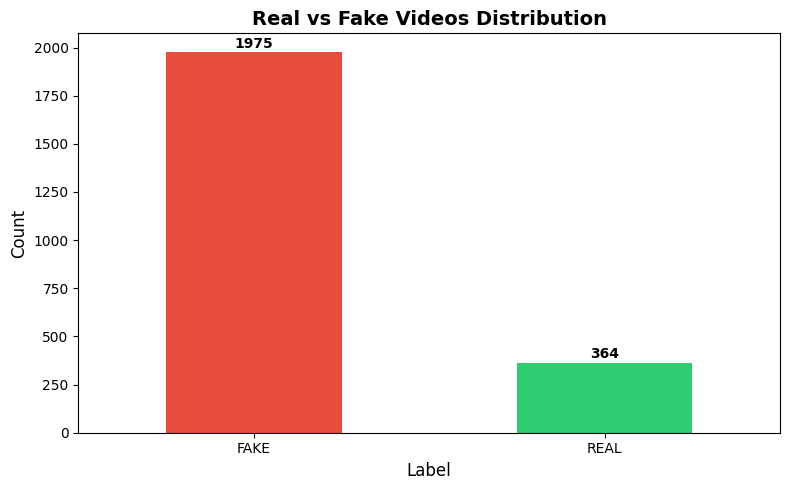

In [ ]:
print("\n" + "="*60)
print("LOADING DATASET METADATA")
print("="*60)

metadata_path = os.path.join(DATASET_PATH, 'metadata.json')

try:
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    print(f"\n✓ Total videos: {len(metadata)}")

    # Analyze labels
    labels = [v['label'] for v in metadata.values()]
    label_counts = pd.Series(labels).value_counts()

    print("\nLabel Distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} ({count/len(labels)*100:.1f}%)")

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ecc71' if l == 'REAL' else '#e74c3c' for l in label_counts.index]
    label_counts.plot(kind='bar', color=colors, ax=ax)
    ax.set_title('Real vs Fake Videos Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Label', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(label_counts.index, rotation=0)

    for i, v in enumerate(label_counts):
        ax.text(i, v + len(metadata)*0.01, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'label_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"\n❌ Error loading metadata: {e}")
    print("Please check if metadata.json exists in the dataset folder")


In [ ]:
class VideoPreprocessor:
    """Extract and preprocess faces from videos"""

    def __init__(self, mtcnn, frame_rate=2, img_size=224):
        self.mtcnn = mtcnn
        self.frame_rate = frame_rate
        self.img_size = img_size

    def extract_frames(self, video_path, max_frames=10):
        """Extract frames from video at specified frame rate"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return []

            fps = int(cap.get(cv2.CAP_PROP_FPS))
            if fps == 0:
                fps = 30

            frame_interval = max(1, fps // self.frame_rate)

            frames = []
            frame_count = 0
            extracted = 0

            while cap.isOpened() and extracted < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_interval == 0:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame_rgb)
                    extracted += 1

                frame_count += 1

            cap.release()
            return frames

        except Exception as e:
            print(f"Error extracting frames: {e}")
            return []

    def detect_and_crop_face(self, frame):
        """Detect and crop face using MTCNN"""
        try:
            boxes, probs = self.mtcnn.detect(frame)

            if boxes is not None and len(boxes) > 0:
                # Get highest confidence detection
                best_idx = np.argmax(probs)
                box = boxes[best_idx]

                # Add margin and crop
                x1, y1, x2, y2 = [int(b) for b in box]
                margin = 20
                h, w = frame.shape[:2]

                x1 = max(0, x1 - margin)
                y1 = max(0, y1 - margin)
                x2 = min(w, x2 + margin)
                y2 = min(h, y2 + margin)

                face = frame[y1:y2, x1:x2]

                if face.size > 0:
                    face_resized = cv2.resize(face, (self.img_size, self.img_size))
                    return face_resized

        except Exception as e:
            pass

        return None

    def process_video(self, video_path, max_frames=10):
        """Extract and process all faces from video"""
        frames = self.extract_frames(video_path, max_frames)
        faces = []

        for frame in frames:
            face = self.detect_and_crop_face(frame)
            if face is not None:
                faces.append(face)

        return faces if len(faces) > 0 else None

# Initialize face detector
print("\n" + "="*60)
print("INITIALIZING FACE DETECTOR")
print("="*60)

mtcnn = MTCNN(
    keep_all=False,
    device=device,
    select_largest=True,
    post_process=False
)
preprocessor = VideoPreprocessor(mtcnn, frame_rate=2, img_size=224)
print("✓ MTCNN face detector initialized")



INITIALIZING FACE DETECTOR
✓ MTCNN face detector initialized


In [ ]:
def process_dataset(metadata, video_dir, output_dir, max_videos=500, frames_per_video=10):
    """Process videos and extract face crops"""

    print("\n" + "="*60)
    print("PROCESSING DATASET")
    print("="*60)

    # Create split directories
    for split in ['train', 'val', 'test']:
        for label in ['real', 'fake']:
            os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

    # Balance and shuffle dataset
    video_items = list(metadata.items())
    random.shuffle(video_items)

    real_videos = [(k, v) for k, v in video_items if v['label'] == 'REAL'][:max_videos//2]
    fake_videos = [(k, v) for k, v in video_items if v['label'] == 'FAKE'][:max_videos//2]

    all_videos = real_videos + fake_videos
    random.shuffle(all_videos)

    # Create splits (70-20-10)
    n_train = int(0.7 * len(all_videos))
    n_val = int(0.9 * len(all_videos))

    splits = {
        'train': all_videos[:n_train],
        'val': all_videos[n_train:n_val],
        'test': all_videos[n_val:]
    }

    stats = {split: {'real': 0, 'fake': 0} for split in ['train', 'val', 'test']}

    # Process each split
    for split_name, videos in splits.items():
        print(f"\n📹 Processing {split_name.upper()} split ({len(videos)} videos)...")

        pbar = tqdm(videos, desc=f"{split_name}")

        for video_name, video_info in pbar:
            video_path = os.path.join(video_dir, video_name)

            if not os.path.exists(video_path):
                continue

            label = 'real' if video_info['label'] == 'REAL' else 'fake'
            faces = preprocessor.process_video(video_path, max_frames=frames_per_video)

            if faces is not None and len(faces) > 0:
                base_name = os.path.splitext(video_name)[0]

                for i, face in enumerate(faces):
                    save_path = os.path.join(
                        output_dir, split_name, label,
                        f"{base_name}_frame_{i:03d}.jpg"
                    )
                    cv2.imwrite(save_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

                stats[split_name][label] += len(faces)
                pbar.set_postfix({'real': stats[split_name]['real'],
                                 'fake': stats[split_name]['fake']})

    # Print statistics
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)

    for split in ['train', 'val', 'test']:
        total = stats[split]['real'] + stats[split]['fake']
        print(f"\n{split.upper()}:")
        print(f"  Real: {stats[split]['real']} ({stats[split]['real']/total*100:.1f}%)")
        print(f"  Fake: {stats[split]['fake']} ({stats[split]['fake']/total*100:.1f}%)")
        print(f"  Total: {total}")

    return stats

# Process dataset
print("\nStarting dataset processing...")
print("⏳ This may take 15-30 minutes depending on dataset size...")

stats = process_dataset(
    metadata,
    DATASET_PATH,
    PROCESSED_PATH,
    max_videos=500,  # Adjust based on your needs
    frames_per_video=10
)



Starting dataset processing...
⏳ This may take 15-30 minutes depending on dataset size...

PROCESSING DATASET

📹 Processing TRAIN split (350 videos)...


train:   0%|          | 0/350 [00:00<?, ?it/s]


📹 Processing VAL split (100 videos)...


val:   0%|          | 0/100 [00:00<?, ?it/s]


📹 Processing TEST split (50 videos)...


test:   0%|          | 0/50 [00:00<?, ?it/s]


PROCESSING COMPLETE

TRAIN:
  Real: 34 (27.4%)
  Fake: 90 (72.6%)
  Total: 124

VAL:
  Real: 20 (66.7%)
  Fake: 10 (33.3%)
  Total: 30

TEST:
  Real: 20 (100.0%)
  Fake: 0 (0.0%)
  Total: 20


In [ ]:
class DeepfakeDataset(Dataset):
    """Dataset for loading preprocessed face images"""

    def __init__(self, root_dir, transform=None, return_sequence=False, seq_length=5):
        self.root_dir = root_dir
        self.transform = transform
        self.return_sequence = return_sequence
        self.seq_length = seq_length

        self.data = []
        self.labels = []

        # Load images
        for label_idx, label in enumerate(['real', 'fake']):
            label_dir = os.path.join(root_dir, label)
            if not os.path.exists(label_dir):
                continue

            files = sorted([f for f in os.listdir(label_dir) if f.endswith('.jpg')])

            if return_sequence:
                # Group frames by video for temporal analysis
                video_groups = {}
                for f in files:
                    video_id = '_'.join(f.split('_')[:-2])
                    if video_id not in video_groups:
                        video_groups[video_id] = []
                    video_groups[video_id].append(os.path.join(label_dir, f))

                # Add sequences
                for video_id, frames in video_groups.items():
                    if len(frames) >= seq_length:
                        frames_sorted = sorted(frames)
                        self.data.append(frames_sorted[:seq_length])
                        self.labels.append(label_idx)
            else:
                # Single frame mode
                for f in files:
                    self.data.append(os.path.join(label_dir, f))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.return_sequence:
            # Return sequence of frames
            frame_paths = self.data[idx]
            frames = []

            for path in frame_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)

            return torch.stack(frames), self.labels[idx]
        else:
            # Return single frame
            img_path = self.data[idx]
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, self.labels[idx]


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\n✓ Data transforms defined")



✓ Data transforms defined


In [ ]:
class FFTFeatureExtractor(nn.Module):
    """Extract frequency-domain features to detect artifacts"""

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(32 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Apply 2D FFT to each channel
        fft_features = []
        for i in range(x.size(1)):
            channel = x[:, i, :, :]
            fft = torch.fft.fft2(channel)
            fft_abs = torch.abs(fft)
            fft_features.append(fft_abs.unsqueeze(1))

        fft_tensor = torch.cat(fft_features, dim=1)

        # Process frequency features
        x = F.relu(self.conv1(fft_tensor))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

class HybridDeepfakeDetector(nn.Module):
    """
    Hybrid deepfake detection model combining:
    - CNN (EfficientNet-B0) for spatial features
    - LSTM for temporal features
    - FFT for frequency-domain artifacts
    """

    def __init__(self, num_classes=2, pretrained=True, use_lstm=False, use_fft=False):
        super().__init__()

        self.use_lstm = use_lstm
        self.use_fft = use_fft

        # CNN Branch: EfficientNet-B0
        self.cnn = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=0)
        cnn_features = self.cnn.num_features  # 1280 for EfficientNet-B0

        # LSTM Branch for temporal consistency
        if use_lstm:
            self.lstm = nn.LSTM(
                input_size=cnn_features,
                hidden_size=256,
                num_layers=2,
                batch_first=True,
                dropout=0.3,
                bidirectional=True
            )
            lstm_features = 512  # bidirectional: 256 * 2
        else:
            lstm_features = 0

        # FFT Branch for frequency analysis
        if use_fft:
            self.fft_extractor = FFTFeatureExtractor()
            fft_features = 128
        else:
            fft_features = 0

        # Fusion and Classification
        total_features = cnn_features + lstm_features + fft_features

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        if self.use_lstm:
            # x shape: (batch, seq_len, channels, height, width)
            batch_size, seq_len = x.size(0), x.size(1)

            # Extract CNN features for each frame
            cnn_feats = []
            for t in range(seq_len):
                feat = self.cnn(x[:, t])
                cnn_feats.append(feat)

            cnn_feats = torch.stack(cnn_feats, dim=1)  # (batch, seq_len, features)

            # LSTM processing
            lstm_out, _ = self.lstm(cnn_feats)
            lstm_feat = lstm_out[:, -1, :]  # Take last timestep

            # Average CNN features across time
            cnn_feat = cnn_feats.mean(dim=1)

            # Combine CNN and LSTM features
            combined = torch.cat([cnn_feat, lstm_feat], dim=1)

        else:
            # Single frame processing
            cnn_feat = self.cnn(x)
            combined = cnn_feat

        # Add FFT features if enabled
        if self.use_fft:
            if self.use_lstm:
                fft_input = x[:, 0]  # Use first frame for FFT
            else:
                fft_input = x

            fft_feat = self.fft_extractor(fft_input)
            combined = torch.cat([combined, fft_feat], dim=1)

        # Classification
        output = self.classifier(combined)
        return output

print("\n✓ Model architecture defined")



✓ Model architecture defined


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/len(dataloader):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs


In [ ]:
def plot_training_history(history, model_name):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name.upper()} - Loss Curves', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name.upper()} - Accuracy Curves', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'training_history_{model_name}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                annot_kws={'size': 14, 'weight': 'bold'})

    plt.title(f'{model_name.upper()} - Confusion Matrix',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Add accuracy text
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    plt.text(1, -0.3, f'Accuracy: {accuracy*100:.2f}%',
             ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'confusion_matrix_{model_name}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true, y_probs, model_name):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b-', label=f'ROC Curve (AUC = {auc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=2)

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name.upper()} - ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'roc_curve_{model_name}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_sample_predictions(model, dataset, device, num_samples=8):
    """Visualize sample predictions"""
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    with torch.no_grad():
        for idx, ax in enumerate(axes):
            img, true_label = dataset[indices[idx]]

            # Predict
            img_batch = img.unsqueeze(0).to(device)
            output = model(img_batch)
            prob = F.softmax(output, dim=1)
            pred_label = output.argmax(1).item()
            confidence = prob[0, pred_label].item()

            # Denormalize image
            img_display = img.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            # Display
            ax.imshow(img_display)
            ax.axis('off')

            true_text = 'Real' if true_label == 0 else 'Fake'
            pred_text = 'Real' if pred_label == 0 else 'Fake'
            color = 'green' if true_label == pred_label else 'red'

            ax.set_title(f'True: {true_text}\nPred: {pred_text} ({confidence:.2%})',
                        color=color, fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'sample_predictions.png'),
                dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def train_model(model_type='cnn', num_epochs=20, batch_size=32, learning_rate=0.0001):
    """
    Train deepfake detection model

    Args:
        model_type: 'cnn', 'cnn_lstm', or 'hybrid'
        num_epochs: number of training epochs
        batch_size: batch size
        learning_rate: learning rate
    """

    print("\n" + "="*60)
    print(f"TRAINING {model_type.upper()} MODEL")
    print("="*60)

    # Configure model
    use_lstm = 'lstm' in model_type
    use_fft = 'hybrid' in model_type
    return_sequence = use_lstm

    print(f"\nConfiguration:")
    print(f"  Model type: {model_type.upper()}")
    print(f"  Use LSTM: {use_lstm}")
    print(f"  Use FFT: {use_fft}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate: {learning_rate}")

    # Create datasets
    print("\n📊 Loading datasets...")

    train_dataset = DeepfakeDataset(
        os.path.join(PROCESSED_PATH, 'train'),
        transform=train_transform,
        return_sequence=return_sequence,
        seq_length=5
    )

    val_dataset = DeepfakeDataset(
        os.path.join(PROCESSED_PATH, 'val'),
        transform=val_transform,
        return_sequence=return_sequence,
        seq_length=5
    )

    test_dataset = DeepfakeDataset(
        os.path.join(PROCESSED_PATH, 'test'),
        transform=val_transform,
        return_sequence=return_sequence,
        seq_length=5
    )

    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Val: {len(val_dataset)} samples")
    print(f"  Test: {len(test_dataset)} samples")

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Create model
    print("\n🧠 Building model...")
    model = HybridDeepfakeDetector(
        num_classes=2,
        pretrained=True,
        use_lstm=use_lstm,
        use_fft=use_fft
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    # Training loop
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"\n📊 Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            model_path = os.path.join(OUTPUT_PATH, f'best_model_{model_type}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, model_path)
            print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{patience})")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model for testing
    print("\n" + "="*60)
    print("LOADING BEST MODEL FOR TESTING")
    print("="*60)

    checkpoint = torch.load(os.path.join(OUTPUT_PATH, f'best_model_{model_type}.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
    print(f"  Best Val Acc: {checkpoint['val_acc']:.2f}%")
    print(f"  Best Val Loss: {checkpoint['val_loss']:.4f}")

    # Test evaluation
    print("\n" + "="*60)
    print("FINAL TEST EVALUATION")
    print("="*60)

    test_loss, test_acc, test_preds, test_labels, test_probs = validate(
        model, test_loader, criterion, device
    )

    print(f"\n📈 Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.2f}%")

    # Detailed metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, test_preds, average='binary'
    )

    print(f"\n📊 Detailed Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    if len(np.unique(test_labels)) == 2:
        auc = roc_auc_score(test_labels, test_probs)
        print(f"  AUC-ROC: {auc:.4f}")

    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(
        test_labels, test_preds,
        target_names=['Real', 'Fake'],
        digits=4
    ))

    # Generate visualizations
    print("\n📊 Generating visualizations...")

    plot_training_history(history, model_type)
    plot_confusion_matrix(test_labels, test_preds, model_type)

    if len(np.unique(test_labels)) == 2:
        plot_roc_curve(test_labels, test_probs, model_type)

    plot_sample_predictions(model, test_dataset, device, num_samples=8)

    print("\n✓ All visualizations saved to:", OUTPUT_PATH)

    return model, history, {
        'test_acc': test_acc,
        'test_loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc if len(np.unique(test_labels)) == 2 else None
    }


In [ ]:
print("\n" + "="*60)
print("READY TO TRAIN MODEL")
print("="*60)



READY TO TRAIN MODEL


In [ ]:
MODEL_TYPE = 'cnn'  # Options: 'cnn', 'cnn_lstm', 'hybrid'
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.0001


In [ ]:
print(f"\nSelected configuration:")
print(f"  Model: {MODEL_TYPE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")

print("\n⚠️  Note: Training may take 1-3 hours depending on:")
print("  - Dataset size")
print("  - GPU availability")
print("  - Model complexity")



Selected configuration:
  Model: cnn
  Epochs: 20
  Batch size: 32
  Learning rate: 0.0001

⚠️  Note: Training may take 1-3 hours depending on:
  - Dataset size
  - GPU availability
  - Model complexity



TRAINING CNN MODEL

Configuration:
  Model type: CNN
  Use LSTM: False
  Use FFT: False
  Epochs: 20
  Batch size: 32
  Learning rate: 0.0001

📊 Loading datasets...
  Train: 124 samples
  Val: 30 samples
  Test: 20 samples

🧠 Building model...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

  Total parameters: 4,796,798
  Trainable parameters: 4,796,798

STARTING TRAINING

Epoch 1/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.7508 | Train Acc: 58.06%
  Val Loss:   0.6918 | Val Acc:   33.33%
  LR: 0.000100


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


  ✓ Best model saved! (Val Acc: 33.33%)

Epoch 2/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.6213 | Train Acc: 66.94%
  Val Loss:   0.6858 | Val Acc:   33.33%
  LR: 0.000100
  No improvement (1/7)

Epoch 3/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.4988 | Train Acc: 76.61%
  Val Loss:   0.6880 | Val Acc:   36.67%
  LR: 0.000100
  ✓ Best model saved! (Val Acc: 36.67%)

Epoch 4/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.4870 | Train Acc: 74.19%
  Val Loss:   0.7090 | Val Acc:   36.67%
  LR: 0.000100
  No improvement (1/7)

Epoch 5/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>    
if w.is_alive():Traceback (most recent call last):

    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
 ^    ^if w.is_alive():^
  ^ ^ ^ ^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    Exception ignored in: <function _ConnectionBase.__del__ at 0x7957007ceca0>
Traceback (most recent cal

Training:   0%|          | 0/4 [00:00<?, ?it/s]

      assert self._parent_pid == os.getpid(), 'can only test a child process' 
       ^ ^ ^ ^ ^^  ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^: ^^can only test a child process^
^^Traceback (most recent call last):
^  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
AssertionErrorOSError: [Errno 9] Bad file descriptor
: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3980 | Train Acc: 83.87%
  Val Loss:   0.7163 | Val Acc:   43.33%
  LR: 0.000100
  ✓ Best model saved! (Val Acc: 43.33%)

Epoch 6/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3479 | Train Acc: 87.10%
  Val Loss:   0.7232 | Val Acc:   46.67%
  LR: 0.000050


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 25

  ✓ Best model saved! (Val Acc: 46.67%)

Epoch 7/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.3305 | Train Acc: 87.10%
  Val Loss:   0.7027 | Val Acc:   46.67%
  LR: 0.000050
  No improvement (1/7)

Epoch 8/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.2650 | Train Acc: 93.55%
  Val Loss:   0.6769 | Val Acc:   50.00%
  LR: 0.000050
  ✓ Best model saved! (Val Acc: 50.00%)

Epoch 9/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.2611 | Train Acc: 94.35%
  Val Loss:   0.6490 | Val Acc:   63.33%
  LR: 0.000050
  ✓ Best model saved! (Val Acc: 63.33%)

Epoch 10/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.2752 | Train Acc: 91.13%
  Val Loss:   0.6098 | Val Acc:   73.33%
  LR: 0.000050


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 25

  ✓ Best model saved! (Val Acc: 73.33%)

Epoch 11/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.2605 | Train Acc: 91.13%
  Val Loss:   0.5868 | Val Acc:   73.33%
  LR: 0.000050
  No improvement (1/7)

Epoch 12/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.2437 | Train Acc: 91.94%
  Val Loss:   0.5806 | Val Acc:   70.00%
  LR: 0.000050
  No improvement (2/7)

Epoch 13/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.1974 | Train Acc: 95.16%
  Val Loss:   0.5746 | Val Acc:   73.33%
  LR: 0.000050
  No improvement (3/7)

Epoch 14/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _ConnectionBase.__del__ at 0x7957007ceca0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 133, in __del__
    self._close()
  File "/usr/lib/python3.12/m


📊 Results:
  Train Loss: 0.1928 | Train Acc: 95.97%
  Val Loss:   0.5579 | Val Acc:   73.33%
  LR: 0.000050
  No improvement (4/7)

Epoch 15/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.1710 | Train Acc: 95.16%
  Val Loss:   0.5288 | Val Acc:   80.00%
  LR: 0.000050
  ✓ Best model saved! (Val Acc: 80.00%)

Epoch 16/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.1749 | Train Acc: 94.35%
  Val Loss:   0.5160 | Val Acc:   80.00%
  LR: 0.000050
  No improvement (1/7)

Epoch 17/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 25

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.1413 | Train Acc: 97.58%
  Val Loss:   0.4903 | Val Acc:   80.00%
  LR: 0.000050
  No improvement (2/7)

Epoch 18/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7957004f6f20>if w.is_alive():
 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
       self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^^ ^ ^ ^   ^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^      ^    ^ ^^^^^^^^
^  File

Training:   0%|          | 0/4 [00:00<?, ?it/s]

^^^^^^^^^^^^^
^can only test a child process^: ^^^AssertionError^^
^^Traceback (most recent call last):
^  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
^^^^^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
^OSError: [Errno 9] Bad file descriptor
^^^^^^
AssertionError: can only test a child process
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recen

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.1003 | Train Acc: 98.39%
  Val Loss:   0.4776 | Val Acc:   80.00%
  LR: 0.000050
  No improvement (3/7)

Epoch 19/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.0878 | Train Acc: 99.19%
  Val Loss:   0.4644 | Val Acc:   80.00%
  LR: 0.000050
  No improvement (4/7)

Epoch 20/20


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.0847 | Train Acc: 99.19%
  Val Loss:   0.4316 | Val Acc:   80.00%
  LR: 0.000050
  No improvement (5/7)

LOADING BEST MODEL FOR TESTING


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


✓ Loaded model from epoch 15
  Best Val Acc: 80.00%
  Best Val Loss: 0.5288

FINAL TEST EVALUATION


Validating:   0%|          | 0/1 [00:00<?, ?it/s]


📈 Test Results:
  Loss: 0.3523
  Accuracy: 85.00%

📊 Detailed Metrics:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

📋 Classification Report:
              precision    recall  f1-score   support

        Real     1.0000    0.8500    0.9189        20
        Fake     0.0000    0.0000    0.0000         0

    accuracy                         0.8500        20
   macro avg     0.5000    0.4250    0.4595        20
weighted avg     1.0000    0.8500    0.9189        20


📊 Generating visualizations...


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


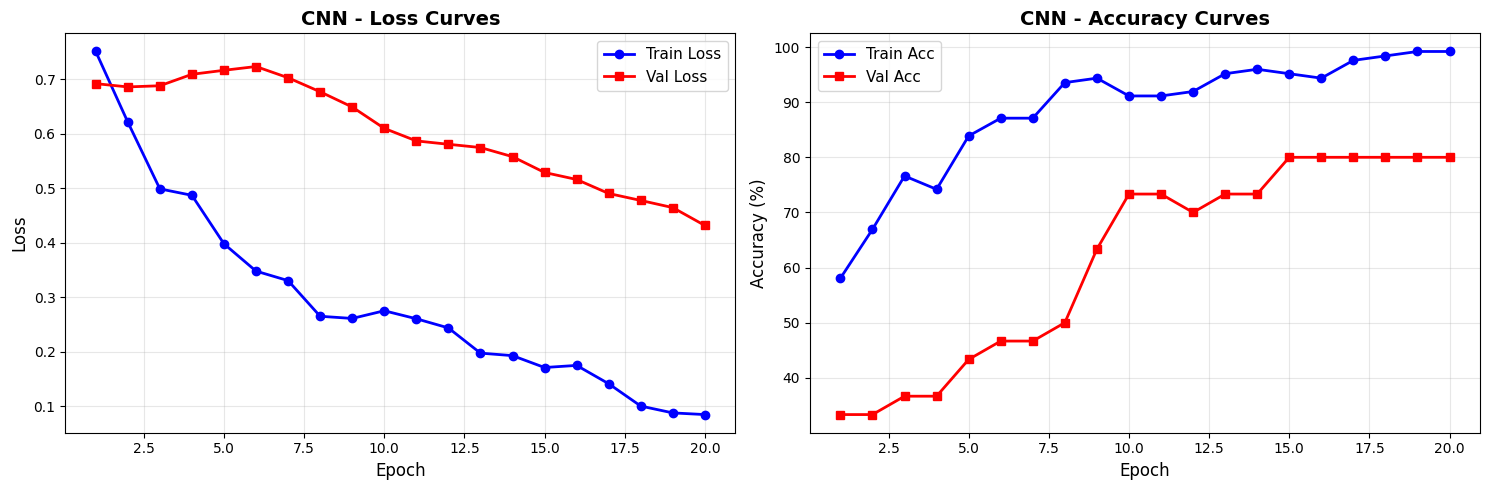

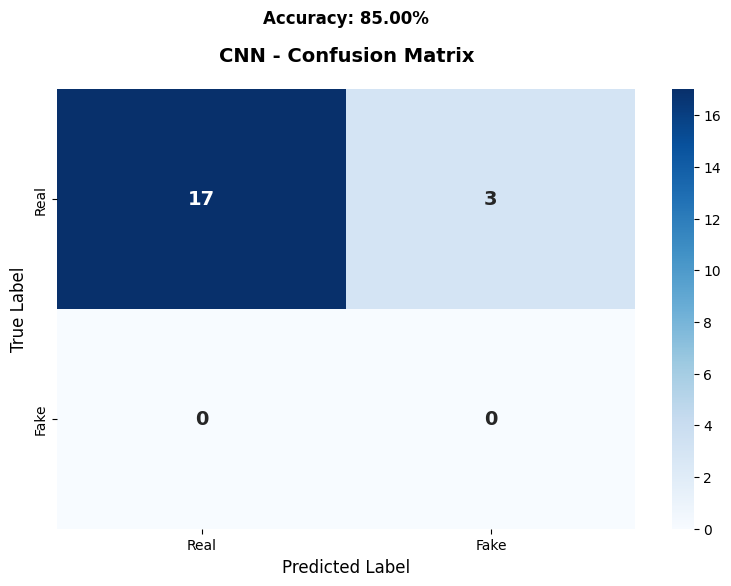

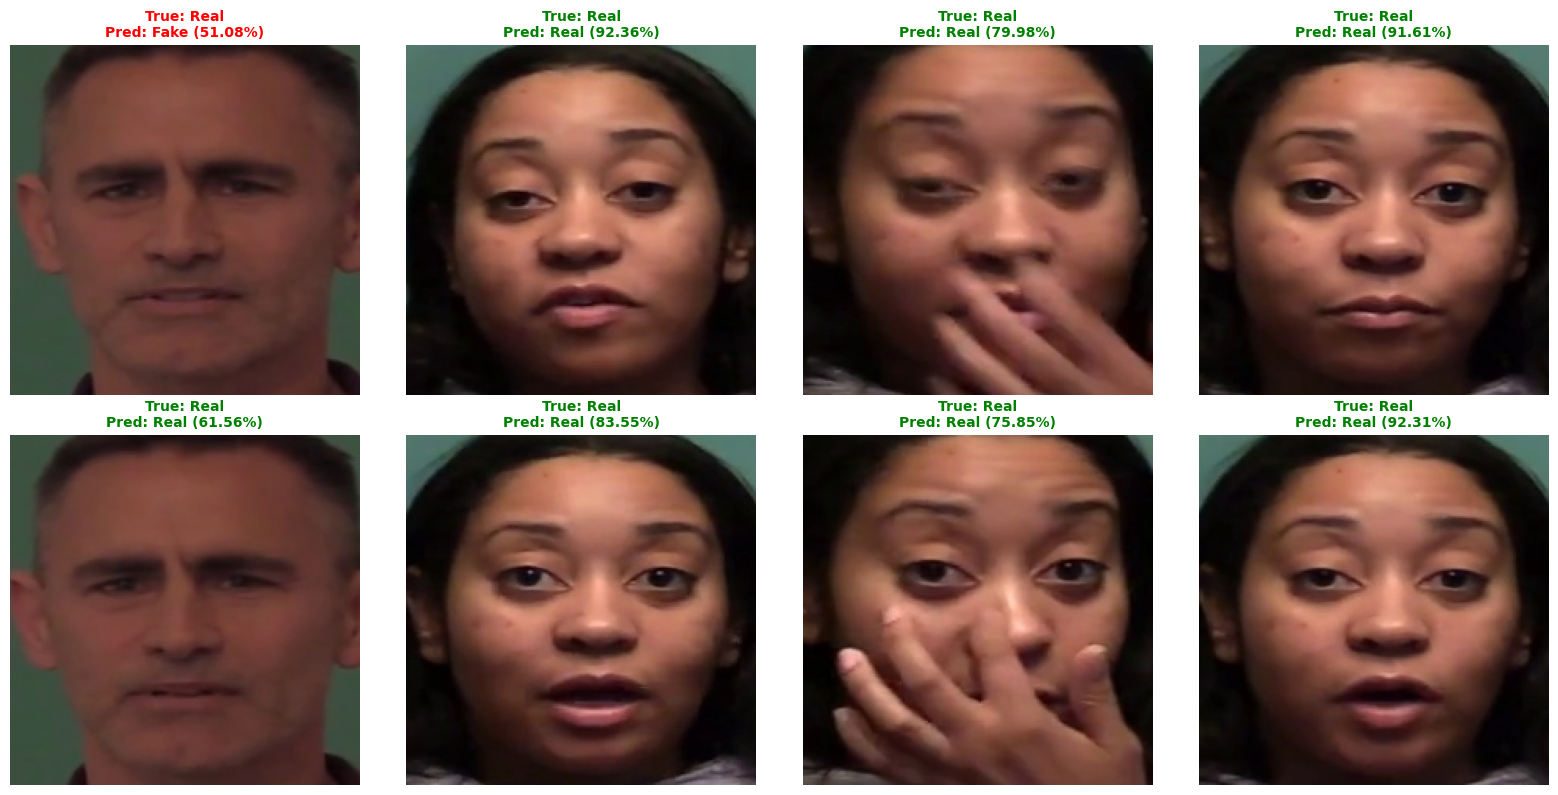


✓ All visualizations saved to: /content/deepfake_output


In [ ]:
model, history, metrics = train_model(
    model_type=MODEL_TYPE,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE
)


In [ ]:
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save metrics
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(OUTPUT_PATH, f'metrics_{MODEL_TYPE}.csv'), index=False)
print(f"✓ Metrics saved")

# Save history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(OUTPUT_PATH, f'history_{MODEL_TYPE}.csv'), index=False)
print(f"✓ Training history saved")

# Summary
print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\n🎯 Final Test Accuracy: {metrics['test_acc']:.2f}%")
print(f"📁 All outputs saved to: {OUTPUT_PATH}")
print(f"💾 Best model saved as: best_model_{MODEL_TYPE}.pth")



SAVING RESULTS
✓ Metrics saved
✓ Training history saved

TRAINING COMPLETE!

🎯 Final Test Accuracy: 85.00%
📁 All outputs saved to: /content/deepfake_output
💾 Best model saved as: best_model_cnn.pth


In [ ]:
def predict_video(video_path, model, preprocessor, device, threshold=0.5, max_frames=10):
    """
    Predict if a video is real or fake

    Args:
        video_path: path to video file
        model: trained model
        preprocessor: VideoPreprocessor instance
        device: torch device
        threshold: classification threshold (default 0.5)
        max_frames: maximum frames to process

    Returns:
        prediction: 'REAL' or 'FAKE'
        confidence: prediction confidence
        frame_probs: probability for each frame
    """

    model.eval()

    # Extract faces from video
    print(f"Processing video: {video_path}")
    faces = preprocessor.process_video(video_path, max_frames=max_frames)

    if faces is None or len(faces) == 0:
        return None, 0.0, None, "No faces detected in video"

    print(f"✓ Extracted {len(faces)} faces")

    # Transform faces
    transform = val_transform
    face_tensors = []

    for face in faces:
        face_pil = Image.fromarray(face)
        face_tensor = transform(face_pil)
        face_tensors.append(face_tensor)

    # Create batch
    batch = torch.stack(face_tensors).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1)
        fake_probs = probs[:, 1].cpu().numpy()

    # Aggregate predictions
    avg_fake_prob = np.mean(fake_probs)
    prediction = 'FAKE' if avg_fake_prob > threshold else 'REAL'
    confidence = avg_fake_prob if prediction == 'FAKE' else (1 - avg_fake_prob)

    print(f"✓ Prediction: {prediction}")
    print(f"✓ Confidence: {confidence:.2%}")
    print(f"✓ Average fake probability: {avg_fake_prob:.2%}")

    return prediction, confidence, fake_probs, None



In [ ]:
print("\n" + "="*60)
print("INFERENCE EXAMPLE")
print("="*60)

print("\nTo test on a new video, use:")
print("""
# Example usage:
test_video_path = '/path/to/your/test_video.mp4'
prediction, confidence, frame_probs, error = predict_video(
    test_video_path,
    model,
    preprocessor,
    device,
    threshold=0.5,
    max_frames=10
)

if error:
    print(f"Error: {error}")
else:
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Frame probabilities: {frame_probs}")
""")



INFERENCE EXAMPLE

To test on a new video, use:

# Example usage:
test_video_path = '/path/to/your/test_video.mp4'
prediction, confidence, frame_probs, error = predict_video(
    test_video_path, 
    model, 
    preprocessor, 
    device,
    threshold=0.5,
    max_frames=10
)

if error:
    print(f"Error: {error}")
else:
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Frame probabilities: {frame_probs}")



In [ ]:
def batch_predict_videos(video_dir, model, preprocessor, device, output_csv=None):
    """
    Predict on multiple videos in a directory

    Args:
        video_dir: directory containing videos
        model: trained model
        preprocessor: VideoPreprocessor instance
        device: torch device
        output_csv: path to save results CSV

    Returns:
        results_df: DataFrame with predictions
    """

    print(f"\n{'='*60}")
    print("BATCH PREDICTION")
    print(f"{'='*60}")

    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
    print(f"Found {len(video_files)} videos")

    results = []

    for video_file in tqdm(video_files, desc="Processing videos"):
        video_path = os.path.join(video_dir, video_file)

        try:
            prediction, confidence, frame_probs, error = predict_video(
                video_path, model, preprocessor, device, max_frames=10
            )

            results.append({
                'video': video_file,
                'prediction': prediction if prediction else 'ERROR',
                'confidence': confidence,
                'num_frames': len(frame_probs) if frame_probs is not None else 0,
                'error': error if error else None
            })

        except Exception as e:
            results.append({
                'video': video_file,
                'prediction': 'ERROR',
                'confidence': 0.0,
                'num_frames': 0,
                'error': str(e)
            })

    results_df = pd.DataFrame(results)

    if output_csv:
        results_df.to_csv(output_csv, index=False)
        print(f"\n✓ Results saved to: {output_csv}")

    # Summary
    print(f"\n{'='*60}")
    print("BATCH PREDICTION SUMMARY")
    print(f"{'='*60}")
    print(f"Total videos: {len(results_df)}")
    print(f"Real: {(results_df['prediction'] == 'REAL').sum()}")
    print(f"Fake: {(results_df['prediction'] == 'FAKE').sum()}")
    print(f"Errors: {(results_df['prediction'] == 'ERROR').sum()}")

    return results_df

# Example usage:
print("\nTo run batch prediction:")
print("""
# Predict on all videos in a directory
results_df = batch_predict_videos(
    video_dir='/path/to/test/videos/',
    model=model,
    preprocessor=preprocessor,
    device=device,
    output_csv=os.path.join(OUTPUT_PATH, 'batch_predictions.csv')
)
""")



To run batch prediction:

# Predict on all videos in a directory
results_df = batch_predict_videos(
    video_dir='/path/to/test/videos/',
    model=model,
    preprocessor=preprocessor,
    device=device,
    output_csv=os.path.join(OUTPUT_PATH, 'batch_predictions.csv')
)



In [ ]:
def compare_models():
    """
    Train and compare different model architectures
    """

    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)

    models_to_compare = ['cnn', 'cnn_lstm', 'hybrid']
    results = []

    for model_type in models_to_compare:
        print(f"\n\n{'='*60}")
        print(f"Training {model_type.upper()} model...")
        print(f"{'='*60}\n")

        try:
            model, history, metrics = train_model(
                model_type=model_type,
                num_epochs=15,  # Fewer epochs for comparison
                batch_size=32
            )

            results.append({
                'model': model_type,
                'test_acc': metrics['test_acc'],
                'test_loss': metrics['test_loss'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics.get('auc', None)
            })

        except Exception as e:
            print(f"❌ Error training {model_type}: {e}")

    # Compare results
    if results:
        comparison_df = pd.DataFrame(results)
        comparison_df = comparison_df.sort_values('test_acc', ascending=False)

        print("\n" + "="*60)
        print("MODEL COMPARISON RESULTS")
        print("="*60)
        print(comparison_df.to_string(index=False))

        comparison_df.to_csv(os.path.join(OUTPUT_PATH, 'model_comparison.csv'), index=False)

        # Visualize comparison
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        metrics_to_plot = ['test_acc', 'precision', 'f1']
        titles = ['Test Accuracy (%)', 'Precision', 'F1-Score']

        for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
            ax = axes[idx]
            comparison_df.plot(x='model', y=metric, kind='bar', ax=ax, legend=False)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Model', fontsize=11)
            ax.set_ylabel('Score', fontsize=11)
            ax.set_xticklabels(comparison_df['model'], rotation=45)

            # Add value labels
            for i, v in enumerate(comparison_df[metric]):
                ax.text(i, v + 0.01, f'{v:.2f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'model_comparison.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

# Uncomment to run model comparison:
# compare_models()

print("\n" + "="*60)
print("🎉 SCRIPT COMPLETE!")
print("="*60)
print(f"\n📁 All outputs saved to: {OUTPUT_PATH}")
print("\n📚 Files generated:")
print("  - best_model_*.pth (trained model)")
print("  - training_history_*.png")
print("  - confusion_matrix_*.png")
print("  - roc_curve_*.png")
print("  - sample_predictions.png")
print("  - metrics_*.csv")
print("  - history_*.csv")



🎉 SCRIPT COMPLETE!

📁 All outputs saved to: /content/deepfake_output

📚 Files generated:
  - best_model_*.pth (trained model)
  - training_history_*.png
  - confusion_matrix_*.png
  - roc_curve_*.png
  - sample_predictions.png
  - metrics_*.csv
  - history_*.csv


In [ ]:
import shutil
import os

# Define the source and destination paths
source_path = OUTPUT_PATH # This is already defined as '/content/deepfake_output'
destination_path = '/content/drive/MyDrive/deepfake_output_backup' # Change this to your desired path in Google Drive

print(f"Copying '{source_path}' to '{destination_path}'...")

try:
    # Copy the entire directory
    shutil.copytree(source_path, destination_path)
    print("✓ Copy complete!")
except FileExistsError:
    print(f"⚠️  Destination directory already exists: {destination_path}")
    print("Please delete the existing directory in your Drive or change the destination path.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

Copying '/content/deepfake_output' to '/content/drive/MyDrive/deepfake_output_backup'...
✓ Copy complete!
